<div class="alert alert-block alert-info">
<strong>Autor:</strong> Ernest López Sánchez
</div>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours

import matplotlib
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
seed = 100

%matplotlib inline

We are going to explore the wine dataset located in the sklearn package.

If you like wine and nice graphical visualizations, you may like this analysis.

The dataset classifies wines in 3 possible classes 0, 1 and 2.
We are going to perform an exploratory analysis on the data.

In [ ]:
from sklearn.datasets import load_wine
data = load_wine(as_frame = True)
target = data['target']
df = data['data']

In [ ]:
print(f"The number of attributes is: {len(df.columns)}")
print(f'The name of the attributes is: {", ".join(df.columns)}')

The number of attributes is: 13
The name of the attributes is: alcohol, malic_acid, ash, alcalinity_of_ash, magnesium, total_phenols, flavanoids, nonflavanoid_phenols, proanthocyanins, color_intensity, hue, od280/od315_of_diluted_wines, proline


In [ ]:
print(f'The number of samples is: {len(df)}')

The number of samples is: 178


In [ ]:
# Check for nulls, there are none.
na_counts = df.isna().sum()
print(na_counts)

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64


## Basic statistical analysis

In [ ]:
# Check the basic statistical values for each feature
basic_measures = df.describe()
print(basic_measures)

          alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453         0.572359   
min         0.9

We are going to base this exploratory data analysis on three of these features so we can perform it more in depth. Let's check alcohol, magnesium and color_intensity.

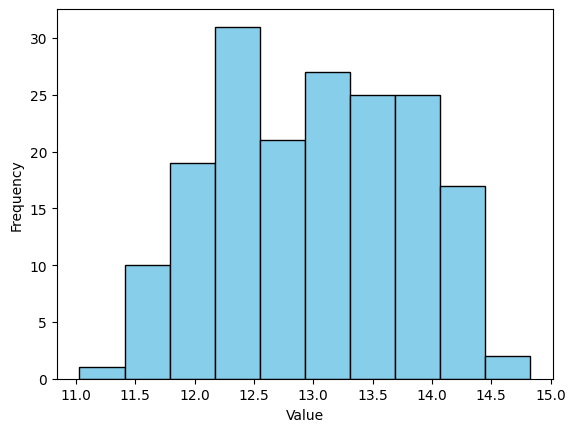

In [ ]:
# Alcohol.
plt.hist(df['alcohol'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

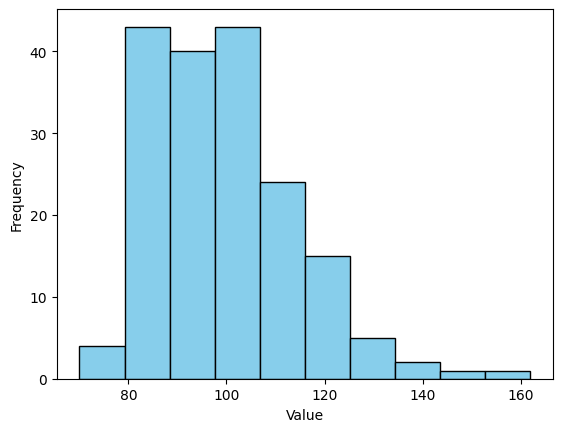

In [ ]:
# Magnesium
plt.hist(df['magnesium'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

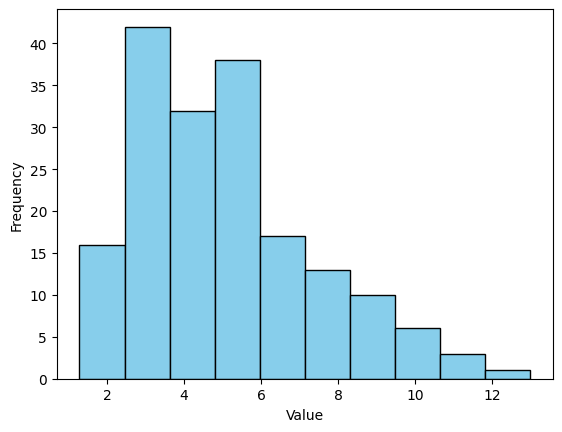

In [ ]:
# Color_intensity.
plt.hist(df['color_intensity'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

We can see that the variable magnesium distributes in a wider range than alcohol and color intensity.

Magnesium and color intensity have similar distribution shape, not taking into account the range of values. Alcohol seems to be more sparsely distributed into its range of values.

Alcohol ranges from 11 to 15 and the majority of data points are located between 12/12.5 and 13/14.

Magnesium has its range between 70 i 160 with the majority of its data points between 80 and 100.

Color intensity has a range between 1 and 13 with most cases between 3 and 6.
The highest values in the intervals seem to be more populated for alcohol than color intensity and magnesium.

## 2.2 Exploratory analisis of the data

We are going to check the relationship between this three features and the outcome, the wine class, we'll do so graphically and we'll check for correlations.

In [ ]:
feats_to_explore = ['alcohol', 'magnesium', 'color_intensity']

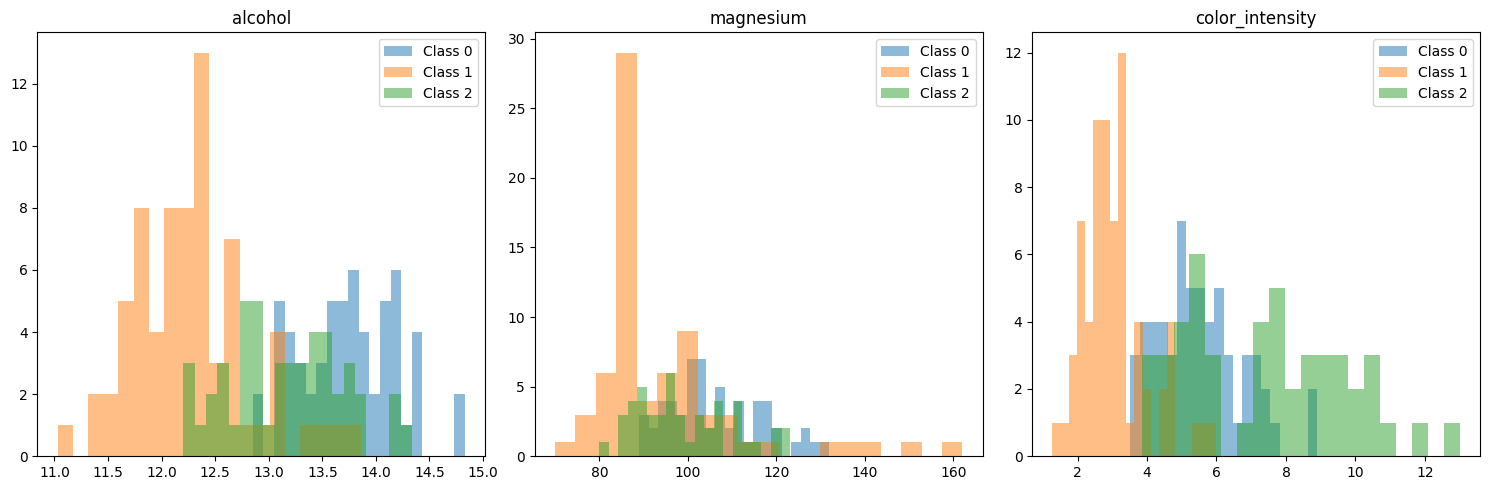

In [ ]:
import numpy as np

df['target'] = target
grouped = df.groupby('target')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, feature in enumerate(['alcohol', 'magnesium', 'color_intensity']):
    ax = axs[i]

    for cls, data in grouped:
        ax.hist(data[data['target'] == cls][feature], bins=20, alpha=0.5, label=f'Class {cls}')

    ax.set_title(feature)
    ax.legend()

plt.tight_layout()
plt.show()

Graphs above show the distribution of values for each variable, segmentated by class of the data points, so we can check for patterns between distribution in value range of variables and the outcome class.

We are trying to check for predictive power associated to variables, if we see strong patterns in a variable this may indicate that this variable has a lot of weight in the outcome class, if we can find any relation between that variable and the outcome class it may indicate that the variable has low weight in predicting the outcome class.

Alcohol seems to have the greatest weight to determine which wine class is an observation. We can easily see that low values of alcohol tend to be class 1, medium values of alcohol tend to be class 2 and high values class 1.
In the other graphics we can see similar patterns but they are not as clear as in alcohol and they seem to overlap the classes in the distribution range, meaning they don't seem to have as much predictive power as alcohol

Magnesium seem to be the feature with less discriminatory weight, all three classes overlap and do not have a clear pattern.

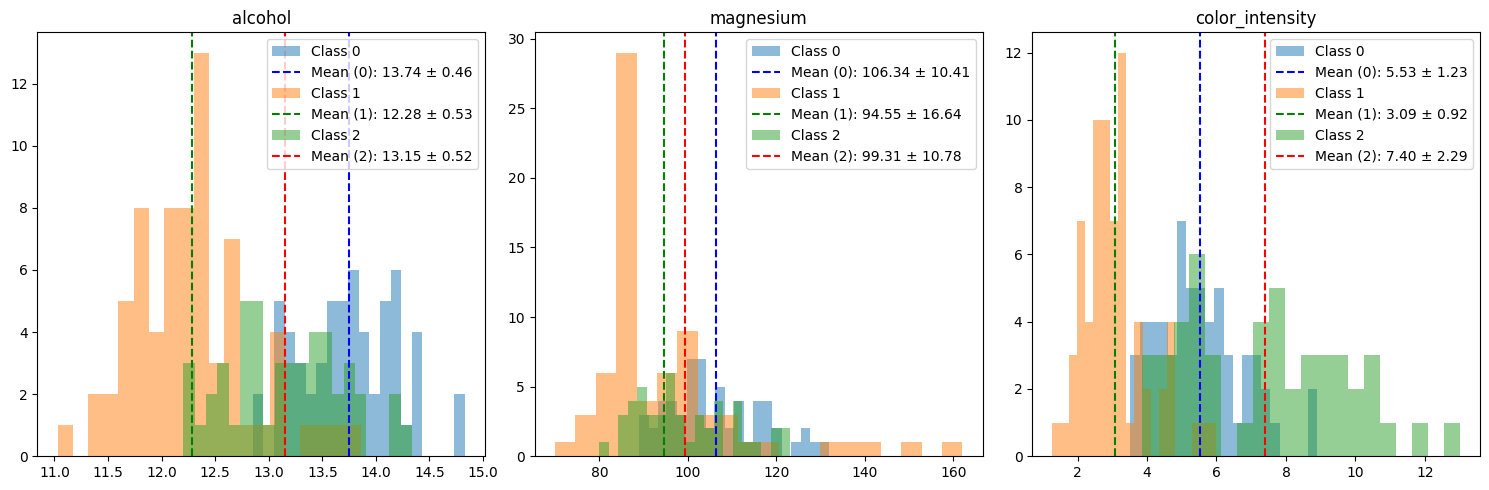

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
colors = ['blue', 'green', 'red']

for i, feature in enumerate(['alcohol', 'magnesium', 'color_intensity']):
    ax = axs[i]

    for idx, cls in enumerate(df['target'].unique()):
        class_data = df[df['target'] == cls][feature]
        counts, bins, _ = ax.hist(class_data, bins=20, alpha=0.5, label=f'Class {cls}')

        mean = np.mean(class_data)
        std_dev = np.std(class_data)

        ax.axvline(mean, color=colors[idx], linestyle='--', label=f'Mean ({cls}): {mean:.2f} ± {std_dev:.2f}')

    ax.set_title(feature)
    ax.legend()

plt.tight_layout()
plt.show()

We have now added the means for each class in each feature and its standard deviation in the legend.


We can see that the mean is very well diferentiated for alcohol and color intensity, I would say that for alcohol discriminates more because of a lower standard deviation, color_intensity although having 3 differentiated means, has std much more higher than alcohol, meaning the distribution of classes inside the variable is not as compact as in alcohol. The std for alcohol is around 3% of the mean while in color intensity its more than 20%.

Magnesium does not seem to have discriminatory power, the means are close to each other and the std is high.

Let's check the correlations

In [ ]:
# Create and check the correlation matrix
correlation_matrix = df[['alcohol', 'magnesium', 'color_intensity']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                  alcohol  magnesium  color_intensity
alcohol          1.000000   0.270798         0.546364
magnesium        0.270798   1.000000         0.199950
color_intensity  0.546364   0.199950         1.000000


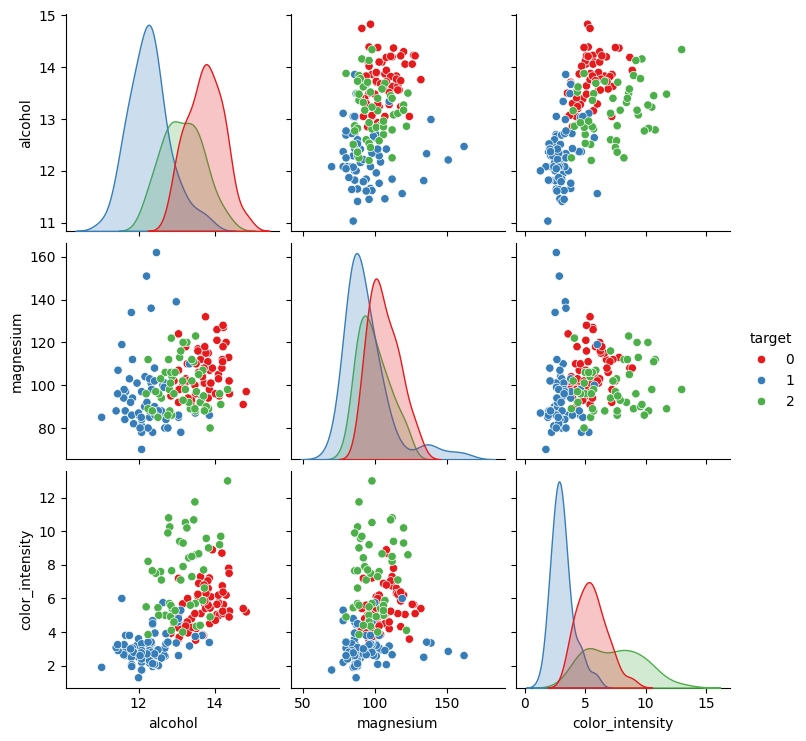

In [ ]:
import seaborn as sns

# Check the pairplots of our three variables.
sns.pairplot(df, vars=['alcohol', 'magnesium', 'color_intensity'], hue='target', palette='Set1')
plt.show()

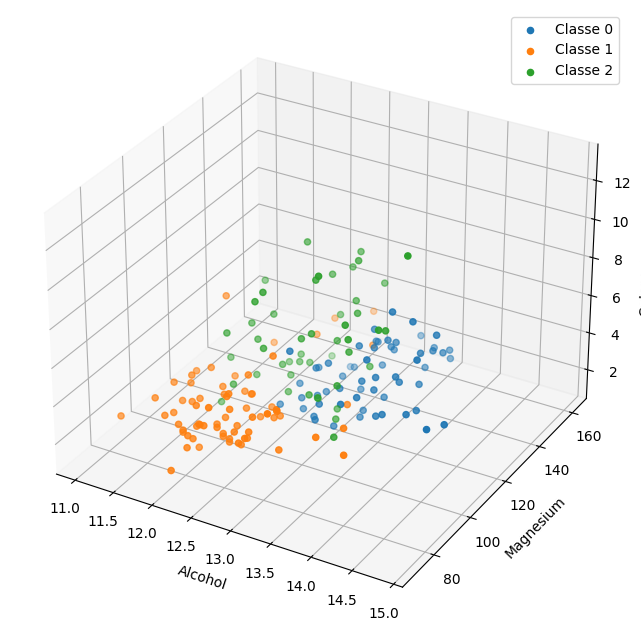

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Graph representing the data points in the three dimensional space,
# using our three features.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for cls in df['target'].unique():
    class_data = df[df['target'] == cls]
    ax.scatter(class_data['alcohol'], class_data['magnesium'], class_data['color_intensity'], label=f'Classe {cls}')

ax.set_xlabel('Alcohol')
ax.set_ylabel('Magnesium')
ax.set_zlabel('Color Intensity')
plt.legend()
plt.show()

Alcohol and color_intensity correlation is bordering between a moderate and strong correlation, 0.52. They are bordering colinearity. Other correlation are not notable, although we could say that magnesium and alcohol have a weak correlation.

If we check the pair plots, we can see that data points are better clustered for alcohol/intensity than for the other variables, that would makes sense with our correlation result.

# Data preprocessing

Let's scale our features:

In [ ]:
from sklearn.preprocessing import StandardScaler
target = df['target']
df.drop(columns = ['target'], inplace=True)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled_features, columns=df.columns)
df_scaled['target'] = target
print(df_scaled.head())

    alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
0  1.518613   -0.562250  0.232053          -1.169593   1.913905   
1  0.246290   -0.499413 -0.827996          -2.490847   0.018145   
2  0.196879    0.021231  1.109334          -0.268738   0.088358   
3  1.691550   -0.346811  0.487926          -0.809251   0.930918   
4  0.295700    0.227694  1.840403           0.451946   1.281985   

   total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
0       0.808997    1.034819             -0.659563         1.224884   
1       0.568648    0.733629             -0.820719        -0.544721   
2       0.808997    1.215533             -0.498407         2.135968   
3       2.491446    1.466525             -0.981875         1.032155   
4       0.808997    0.663351              0.226796         0.401404   

   color_intensity       hue  od280/od315_of_diluted_wines   proline  target  
0         0.251717  0.362177                      1.847920  1.013009       0  
1        -0.

Let's train test split the data.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_scaled, df_scaled['target'], test_size=0.2, random_state=42)

Data has to be scaled before the train_test_split.

Mainly because we avoid bias, the distribution of the values of data in testing and training data may not be the same, so if we scale after splitting we'll have scaling differences between our training and test data.

Thus training the model in a different scale than the one in which it will be tested.

Scaling before the train test split allows to not worry about this problem.


Almost always its mandatory to scale data.

The main reason is that algorithms based in regression and classification, specifically those based on distance, will have better results using scaled data. Results will be more consistent. If we have a big variance in our data, the algorithm will not perform as well.

It also facilitates the comparison of data points in the multidimensional space, k-means(not supervised) and knn are dependent of a correct scaling of our data, for example.

It's also really important when we have outliers in our data, scaling allows to reduce the impact of these outliers in the model conclusions.

# Dimensionality reduction

We are going to perform a PCA into 2 components to represent it graphically and check for patterns.

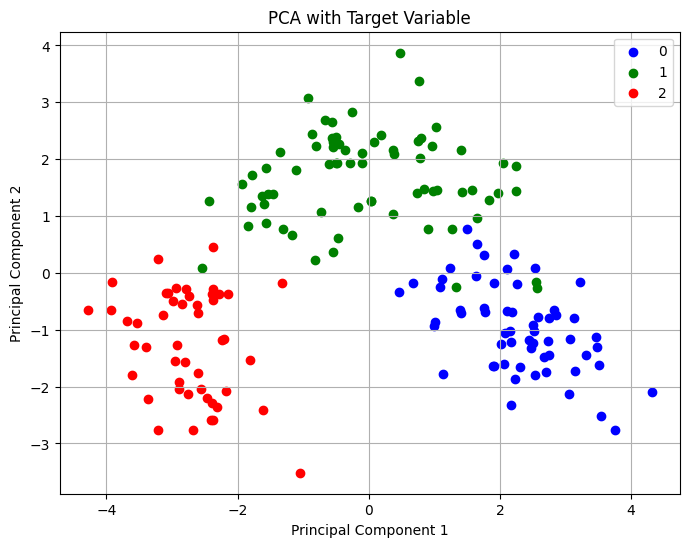

In [ ]:
from sklearn.decomposition import PCA
df_scaled = pd.DataFrame(scaled_features, columns=df.columns)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_with_target = pd.concat([pca_df, target], axis=1)
plt.figure(figsize=(8, 6))
targets = pd.unique(target)
colors = ['b', 'g', 'r'][:len(targets)]
for target_value, color in zip(targets, colors):
    subset = pca_with_target[pca_with_target['target'] == target_value]
    plt.scatter(subset['PC1'], subset['PC2'], label=target_value, color=color)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA with Target Variable')
plt.legend()
plt.grid(True)
plt.show()

Now we are going to perform a TSNE that does the same as PCA but captures non linearity of the data in its components.

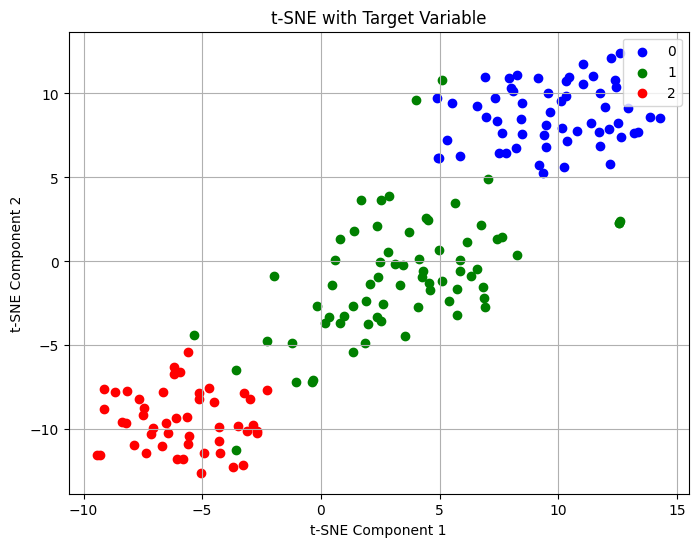

In [ ]:
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(df_scaled)
tsne_df = pd.DataFrame(data=tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_with_target = pd.concat([tsne_df, target], axis=1)
plt.figure(figsize=(8, 6))
targets = pd.unique(target)
colors = ['b', 'g', 'r'][:len(targets)]
for target_value, color in zip(targets, colors):
    subset = tsne_with_target[tsne_with_target['target'] == target_value]
    plt.scatter(subset['TSNE1'], subset['TSNE2'], label=target_value, color=color)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE with Target Variable')
plt.legend()
plt.grid(True)
plt.show()

Results differ in scale and clarity but they same to convery the same.
Reducing our features to two components seem to be enough to explain the outcome.

The data points on the left seem to be class 2, data points on the middle class 1 and data points on the right seem to be class 0.

This applies for both methods. TSNE seems to "cluster" much better, it also brings a strong correlation between both components that PCA is not able to get.(When comp1 value is low comp2 value is also low, same for medium and high).

That may be like that because TSNE captures non linearity in its components while PCA does not. So TSNE is able to provide better graphical results, it captures the diferences and patterns in data points more effectively than PCA that does only use linearity.

TSNE has a weak spot, that is precisely the one where PCA excels, explainability. PCA allows to know which features contribute to each component and how much, TSNE does not allow for any explainability, making a TSNE a nice to have tool but that does not fully perform when you need to get explanations and solutions beyond examining data structure.

# Unbalance datasets

We are going to test sampling methods in an unbalance dataset that has engine data, this data set is really unbalanced having 20530 samples that belong to non-failure class and only 100 to the failure class, let's see how we can deal with that.

In [ ]:
engine_df = pd.read_csv('Turbo_engine.csv', sep=';')
target_feat = 'y'
x1_feat = 'x_1'
x2_feat = 'x_2'

engine_df.head()

x_1    x_2  y
0    1  64182  0
1    2  64215  0
2    3  64235  0
3    4  64235  0
4    5  64237  0

Let's inspect our target value distribution

In [ ]:
def show_distribution(df):
    freq = df[target_feat].value_counts()
    plt.pie(freq, labels=('No engine failure ('+str(freq[0])+')', 'Engine failure ('+str(freq[1])+')'), autopct='%1.1f%%')
    plt.title("Engine failure distribution")

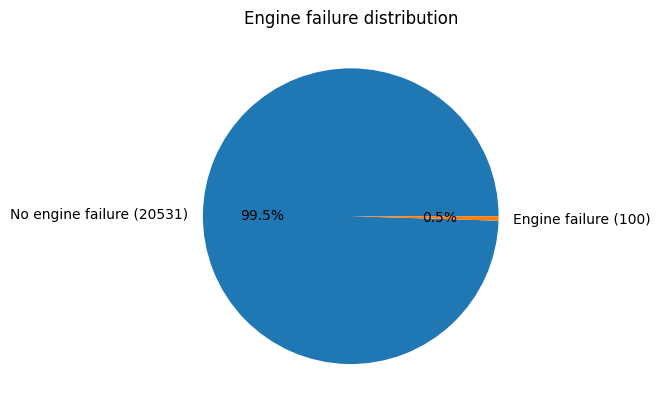

In [ ]:
show_distribution(engine_df)

The dataset as seen is very unbalanced we only have a 0.5% of positive classes in the data.

We'll take advantadge of only having two features and we will represent a linear classifier graphically.

In [ ]:
def plot_data(data_sets, only_failures=False, cmap='Paired'):

    if not isinstance(data_sets, list):
        data_sets = [data_sets]

    colors = np.array(["skyblue", "red"])
    fig, ax = plt.subplots(len(data_sets), 1, figsize=(12, 7 * len(data_sets)))

    for i, data in enumerate(data_sets):
        data = data if not only_failures \
            else data[data[target_feat] == 1]

        eff_ax = ax if len(data_sets) == 1 else ax[i]
        X = data[[x1_feat, x2_feat]].values
        y = data[target_feat].values

        if not only_failures:
            clf = LinearDiscriminantAnalysis()
            clf.fit(X, y)

            h = 2
            x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
            y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h

            xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                                 np.arange(y_min, y_max, h))

            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)

            eff_ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
            eff_ax.contour(xx, yy, Z, colors='black', linewidths=0.7)

        eff_ax.scatter(X[:,0], X[:,1], c=colors[y], cmap=cmap, edgecolors='k')

<ipython-input-84-e7791bd4159b>:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  eff_ax.scatter(X[:,0], X[:,1], c=colors[y], cmap=cmap, edgecolors='k')


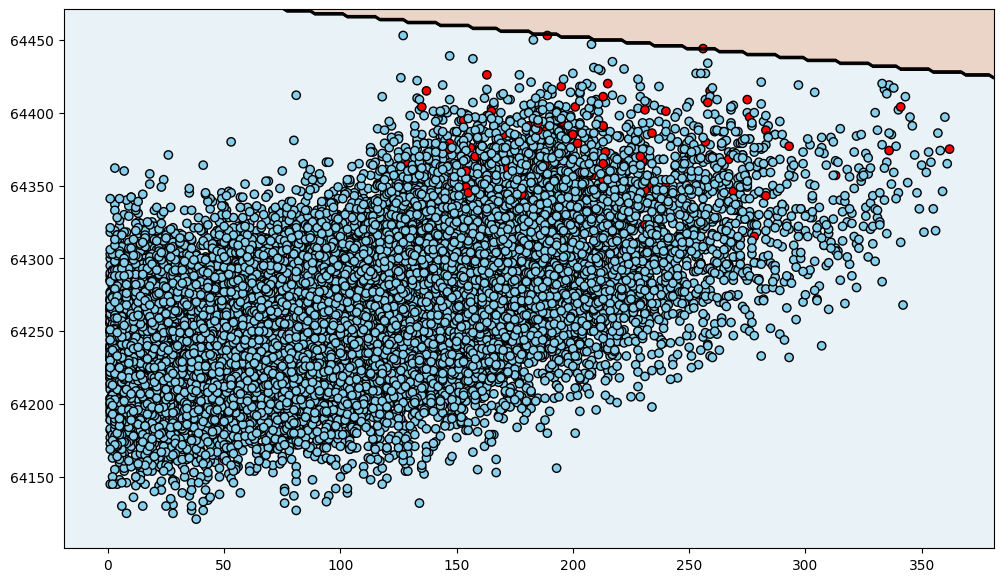

In [ ]:
plot_data([engine_df], only_failures=False)

We can see the distribution of our data. As seen there is a low rate of failures. We can see the lineal frontier to classify classes. Only 2 datapoints are classified as failure. Let's explain why our Linear Classifier draws this lineal border.

This division is done by the lineal classifier because its the most efficient and accurated way to classify this dataset using a lineal border. It's the optimal solution, you can't classify anymore points correctly drawing another lineal border.

If we changed this border, we may classify more positives correctly but the amount of negatives classified as positive will outweight the gains in terms of accuracy and precision.

This is also more efficient than predicting always 0, because here we are correctly labelling 2 positives.

The metric to use to evaluate our metric in this situations where this a low rate of positive class is recall. Recall will check how many of the total positive datapoints where actually classfied as positive.

This is used when we appreciate more predicting the positive class than failing some negatives that will be classified as positives.

Our recall is 2/100 = 2% which means we have no discriminatory power to predict the positive class even though we may got a skyrocket high accuracy and precision.

The solution to this is oversampling.

Let's analyze how the various methods of oversampling change our problem

## 5.1 Oversampling

We are going to oversample our original data with various techniques and let's see what's the final distribution of the target and how our positive class is distributed in the 2 dimensional space.

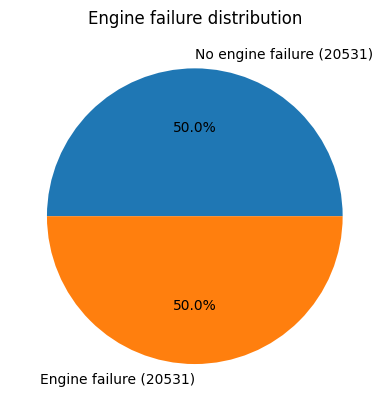

In [ ]:
# Aleatory duplication.
X = engine_df.drop(columns=['y'])
y = engine_df['y']

random_over_sampler = RandomOverSampler(random_state=10)

# Oversampling.
X_resampled, y_resampled = random_over_sampler.fit_resample(X, y)
resampled_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['y'])], axis=1)
show_distribution(resampled_df)

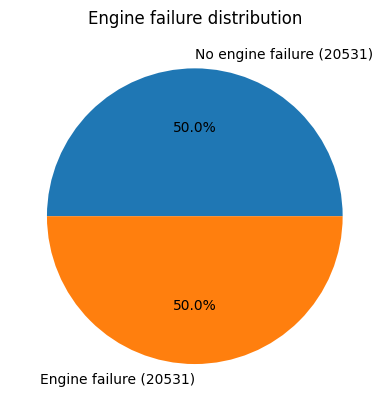

In [ ]:
# SMOTE.
smote = SMOTE(random_state=10)

# Oversampling.
X_smote, y_smote = smote.fit_resample(X, y)
smote_df = pd.concat([pd.DataFrame(X_smote, columns=X.columns), pd.DataFrame(y_smote, columns=['y'])], axis=1)
show_distribution(smote_df)

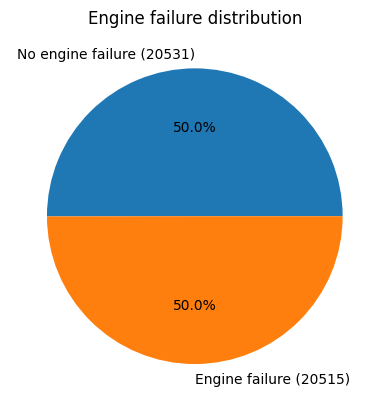

In [ ]:
# ADASYN.
adasyn = ADASYN(random_state=10)

# Oversampling.
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)
adasyn_df = pd.concat([pd.DataFrame(X_adasyn, columns=X.columns), pd.DataFrame(y_adasyn, columns=['y'])], axis=1)
show_distribution(adasyn_df)

<ipython-input-84-e7791bd4159b>:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  eff_ax.scatter(X[:,0], X[:,1], c=colors[y], cmap=cmap, edgecolors='k')
<ipython-input-84-e7791bd4159b>:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  eff_ax.scatter(X[:,0], X[:,1], c=colors[y], cmap=cmap, edgecolors='k')


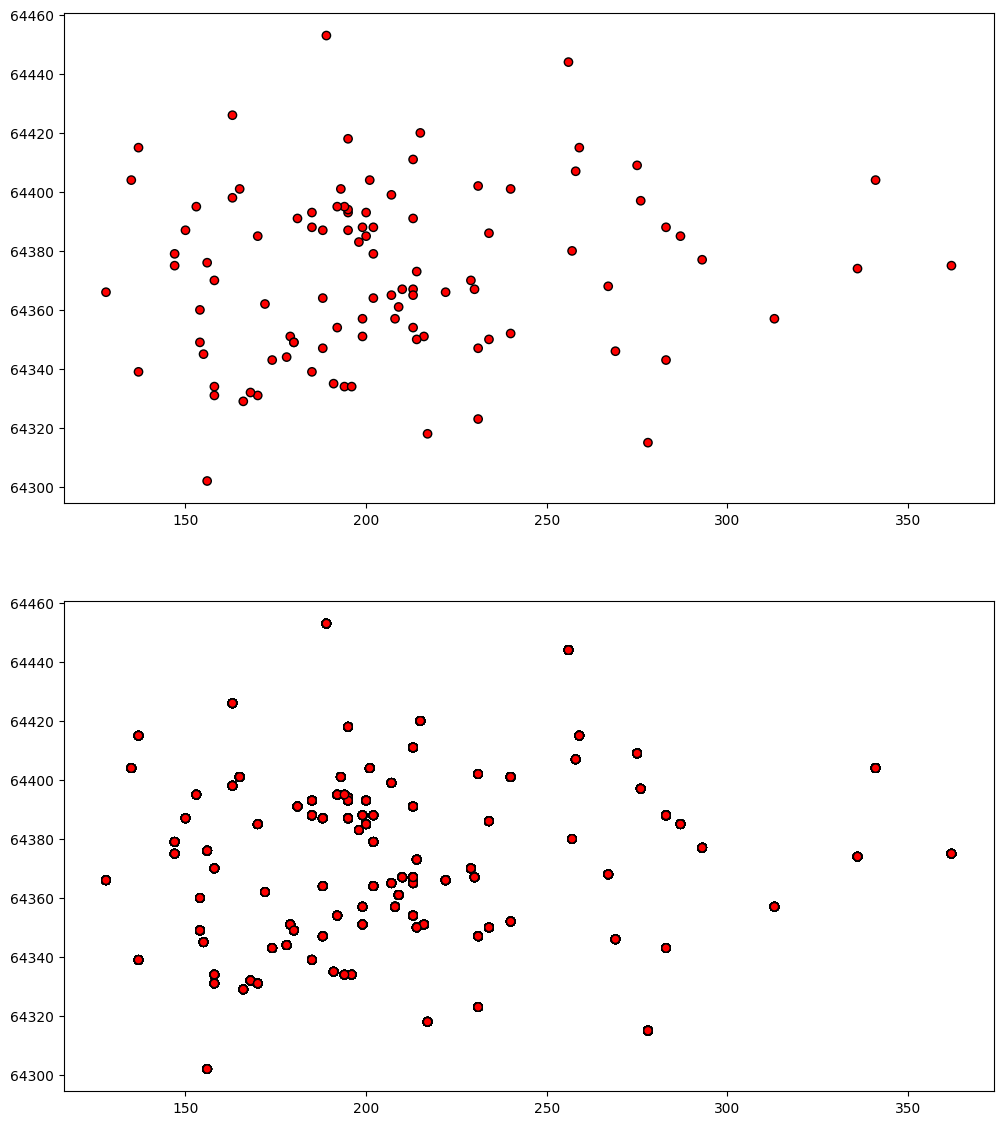

In [ ]:
plot_data([engine_df, resampled_df], only_failures=True)

Both graphics look exactly the same, that's correct and it's because random oversampling, the first technique, simply duplicates data points, so now instead of 100 positive observations we got 20531, 20431 of which are simply exact copies of the original 100, this means they will be located at the same location in the 2d space as the original 100, thus the graphic of distribution of our positive data will not change.

<ipython-input-84-e7791bd4159b>:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  eff_ax.scatter(X[:,0], X[:,1], c=colors[y], cmap=cmap, edgecolors='k')
<ipython-input-84-e7791bd4159b>:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  eff_ax.scatter(X[:,0], X[:,1], c=colors[y], cmap=cmap, edgecolors='k')


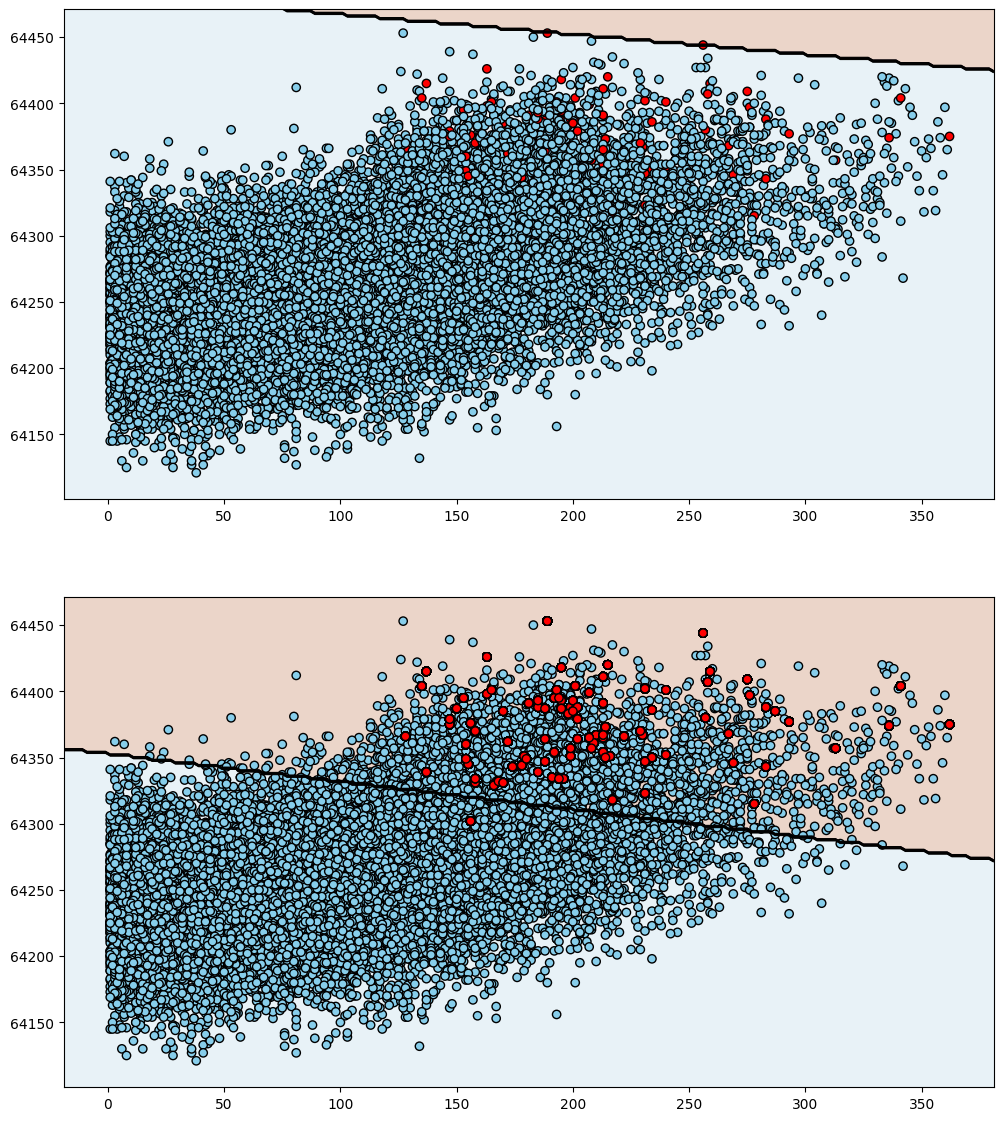

In [ ]:
plot_data([engine_df, resampled_df])

We are now checking how our linear classifier changes after oversampling with the random oversampling technique.

We can see that the classification border has become much more lower.

The classifier has drawn the line that classifies the maximum number of data points correctly, now our data has a 50/50 target distribution so for the classifier it is worth it to lower the border and correctly classify most of the positive class. This border maximizes the overall accuracy of the model given you can only use lineal borders.

In this case our recall has improved a lot, because now we are nearly classifying all positive data points correctly, but we trade it off for precision, our precision will drop, because now we are also clasifying lots of negative class points as positives. Yet the overall accuracy is still pretty high.

So we traded off recall for precision.

If we wanted to get a better solution, we should use random forests or neural networks that use non linear activation functions.

Now let's check what has done to the positive class our other techniques SMOTE and ADASYN.

<ipython-input-84-e7791bd4159b>:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  eff_ax.scatter(X[:,0], X[:,1], c=colors[y], cmap=cmap, edgecolors='k')
<ipython-input-84-e7791bd4159b>:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  eff_ax.scatter(X[:,0], X[:,1], c=colors[y], cmap=cmap, edgecolors='k')
<ipython-input-84-e7791bd4159b>:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  eff_ax.scatter(X[:,0], X[:,1], c=colors[y], cmap=cmap, edgecolors='k')


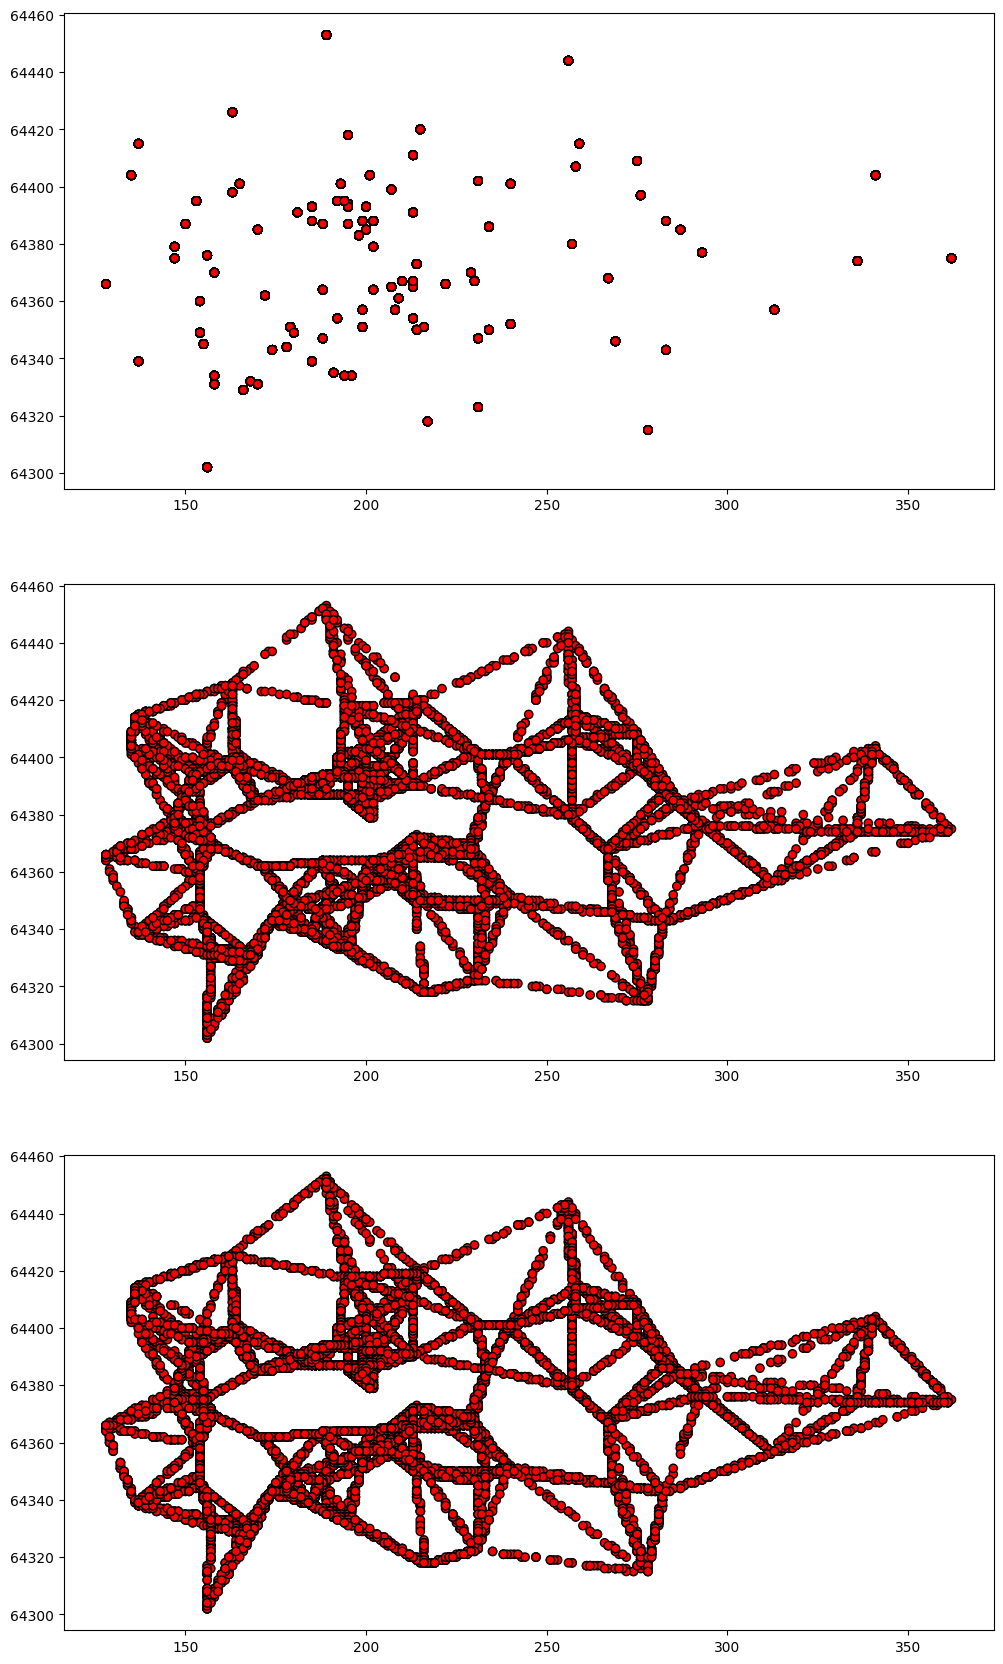

In [ ]:
plot_data([resampled_df, smote_df, adasyn_df], only_failures=True)

In the first graph we see again the effects of random oversampling, as already said, it simply duplicates data points so the distribution graphic remains the same.

SMOTE generates synthetic samples by using interpolation, which is comparing data points and filling the distance between them with samples. That's why in the second graph we can see linear relations.

SMOTE has fill with samples the coordinates in the 2d space where the positive data points use to be.

Third graphic its ADASYN, it seems the same as SMOTE but it is not. The theoretical definition says that ADASYN gives more weight to data points that are poorly represented in the overall distribution, so the algorithm will later be able to learn and classify the extreme points as well, so basically it makes outliers less outliers. The utility deriving from this differs depending on your dataset, for this dataset in this not really have a strong impact.

Let's check now all the data points not only the positive class.

<ipython-input-84-e7791bd4159b>:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  eff_ax.scatter(X[:,0], X[:,1], c=colors[y], cmap=cmap, edgecolors='k')
<ipython-input-84-e7791bd4159b>:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  eff_ax.scatter(X[:,0], X[:,1], c=colors[y], cmap=cmap, edgecolors='k')
<ipython-input-84-e7791bd4159b>:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  eff_ax.scatter(X[:,0], X[:,1], c=colors[y], cmap=cmap, edgecolors='k')


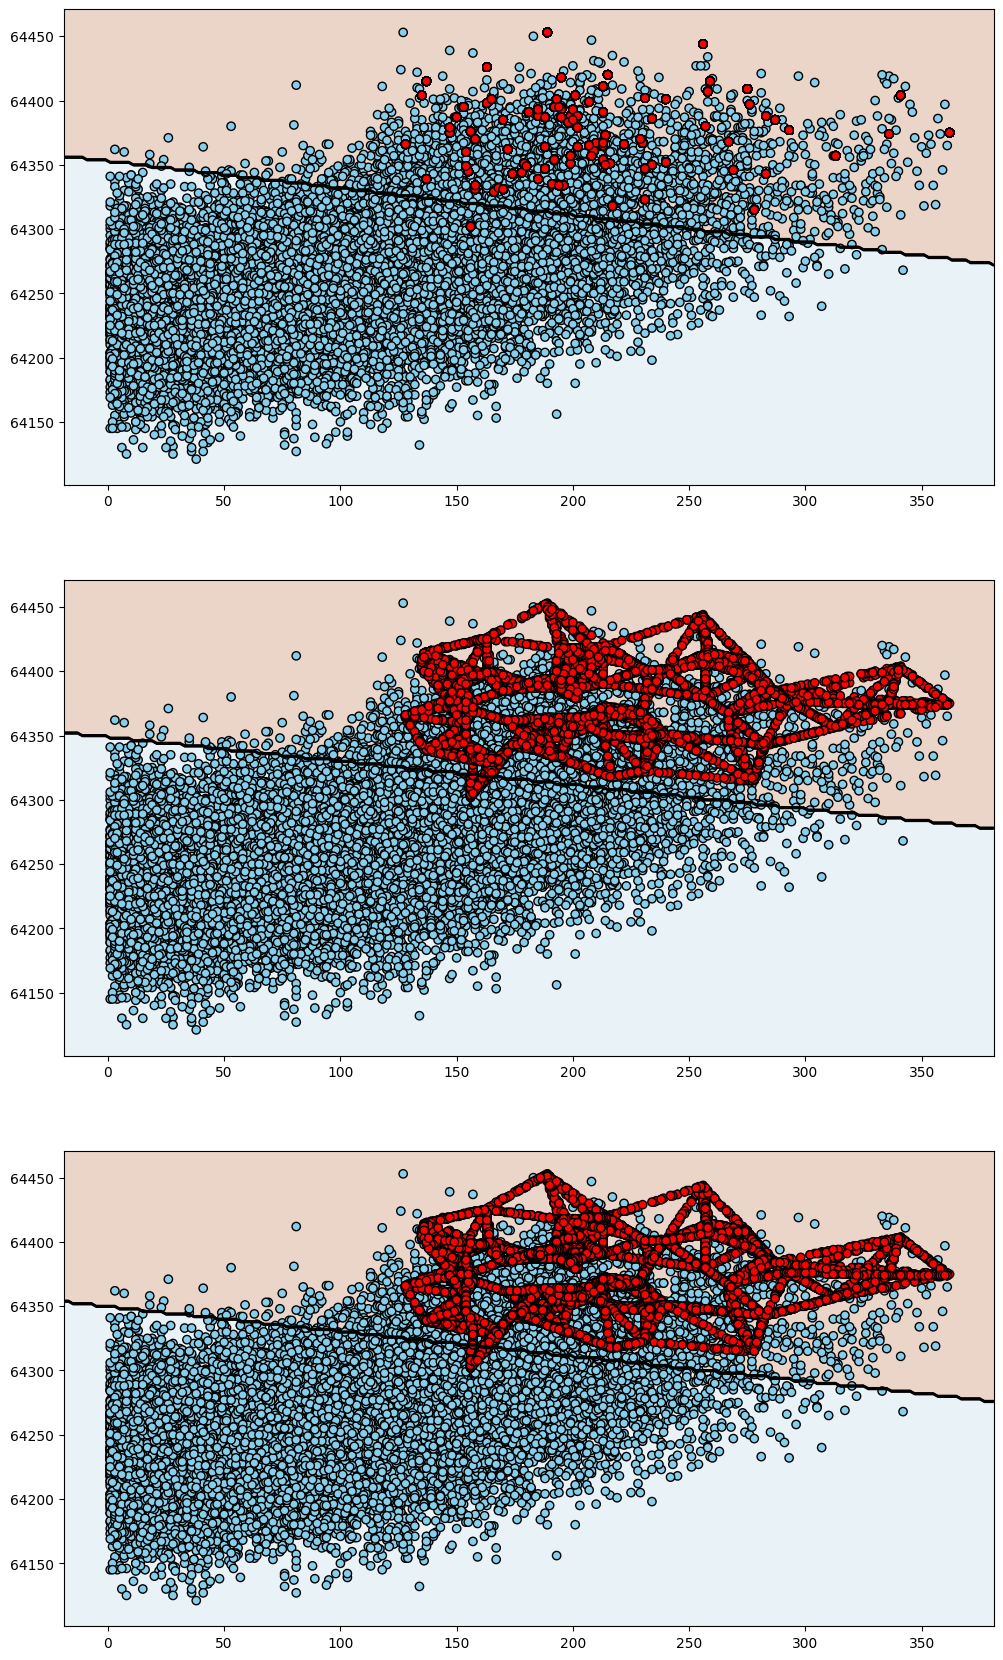

In [ ]:
plot_data([resampled_df, smote_df, adasyn_df])

We can see that the border does not really change between oversampling techniques.

Once we perform oversampling it seems not important which technique we use, that's mainly because using only linearity you can not really improve this result.

There is only one positive point outside the classifier border, for the random oversampling this is the original point and its copies exactly at the same location. And for the other two techniques its the original point and the ones generate to fill the distance between that point and the neighbouring ones.

Overal precision may change lightly but it seems to be residual between techniques.

For this dataset, it seems like SMOTE and ADASYN only contribute to having a more realistic distribution of the possitive class data points. It does not seem to influence the classifier.

If we wanted to get a better result we should explore non linearity or also draw more line borders.

Sampling techniques must be applied after the train test split and only to the training data, we have to ensure that test data is not affected.

The objective of the training procés is that the model learn a generalization of the relation between the variables and the outcome so it can later be applied to reality, to the test data.

We have to understand that by applying SMOTE, ADASYN and Random OverSampling we are sacrificing precision in exchange of recall.

We do this because for whatever reason we value much more the detection of the positive samples than the % of errors we will lose in the false positive data points.

We are then, teaching our model a generalization that is not real, data does not distribute like that in the testing and in the reality.

But by that way we manipulate our model to get a desired recall even though we lose some precision. Our intention is that when we test the model against the test data we get a desired result of balanced recall, precisión and accuracy.

We could have trained the model with the real distribution but this would mean it has no predictive power for the positive class, that is what we are looking for, so we then trade off the precision for recall until it meets our desired needs.